# DM-44574: WET-006  test: plots of pairing vs stacking 

Load stacking result for a particular combination of  mask use / add background / algorithm combination 

In [63]:
import numpy as np

summary = {}

use_mask = True
method = 'tie'


stacking_results = {}

# read the results for TIE, use mask, no bkgnd 
fname = 'wep_direct_stacking_use_mask_tie_no_bkgnd.npy'
stacking_results[0] = {'use_mask':True, 'mask_string':'use',
                       'method':'tie', 
                       'method_string': f'stacking_tie_use_mask',
                       'add_bkgnd':False, 'bkgnd_string': 'no',
                       
                  'fname' :fname,
                 'results':np.load(fname, allow_pickle=True).item()
                 }

# read the results for {TIE, Danish} x {use / no mask}  ,  with background added (if using mask) 
i=1
for use_mask in [True, False]:
    for method in ['tie', 'danish']:
        add_bkgnd = True

        # set the file name title 
        mask_string = 'no' 
        if use_mask: mask_string = 'use'
        
        bkgnd_string = 'no'
        if add_bkgnd: bkgnd_string = 'with'
        fname = f'wep_direct_stacking_{mask_string}_mask_{method}_{bkgnd_string}_bkgnd.npy'
        results = np.load(fname, allow_pickle=True).item()

    
        method_string = f'stacking_{method}_{mask_string}_mask'
       
        if mask_string == 'use' :
            method_string += f'_{bkgnd_string}_bkgnd'
        

    
        stacking_results[i] = {'use_mask':use_mask, 
                               'mask_string':mask_string,
                               'method':method,
                               'method_string':method_string,
                               'add_bkgnd':add_bkgnd,
                               'bkgnd_string':bkgnd_string,
                               'fname':fname,
                               'results':results
                               }
        i += 1 

can summarize the results for all rafts / states with that stacking / algoritm combination ... 

## Get the pairing results from butler:

In [3]:
from lsst.daf import butler as dafButler
butlerRootPath = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo'

butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
output_collection = 'all_states_direct_TIE'
datasetRefs = registry.queryDatasets('donutStampsExtra', collections=[output_collection],
                                     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded()
             # where=f"instrument='LSST{butlerInstName}' and detector in (199) ").expanded()
print(len(list(datasetRefs)))
refs = []
for ref in datasetRefs:
    refs.append(ref)
print(len(refs))

#stackedIntra

400
400


In [45]:
pairing_results = {'tie':{}, 'danish':{}}
for method in pairing_results.keys():
    pairing_results[method] = {}
    for state in range(1,101):
        pairing_results[method][state] = {}
        
for ref in refs:
    #print(ref.dataId)

    # read in the results of each method 
    for method in pairing_results.keys():
        if method == 'tie':
            coll_method = 'TIE'  
        else:
            coll_method = 'Danish'
        coll = f'all_states_direct_{coll_method}'
        state = int(str(ref.dataId.visit.id)[-3:]) 
        raft = ref.dataId.detector.raft
        
        pairing_results[method][state][raft] =  butler.get('zernikeEstimateRaw', 
                          dataId=ref.dataId, 
                          collections=[coll])

## Load OPDs 

In [7]:
# load all OPDs to a dict
from astropy.io import fits

all_opd = {}
for n in range(1,101):#101):
    opdDir = f'/sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_lsstcam/state_{n}'

    hdul = fits.open(os.path.join(opdDir,'opd.fits'))

    
    opds = {}
    for i in range(len(hdul)):
        opd_zks_1_28 = []
        for key,value in hdul[i].header.items():
            
            if key.startswith('AZ'):
                #print(key.split('_')[1])
                opd_zks_1_28.append(value)
        opds[i] = opd_zks_1_28
    all_opd[n]  = opds
    
opd_raft_to_id = {'R00':0, 'R04':1, 'R40':2, 'R44':3}  


## Illustrate the difference for a particular state:

In [114]:
stacking_results[0].keys()

dict_keys(['use_mask', 'mask_string', 'method', 'add_bkgnd', 'bkgnd_string', 'fname', 'results'])

Text(0.5, 0.98, 'WET-006 lsstCam, state 5')

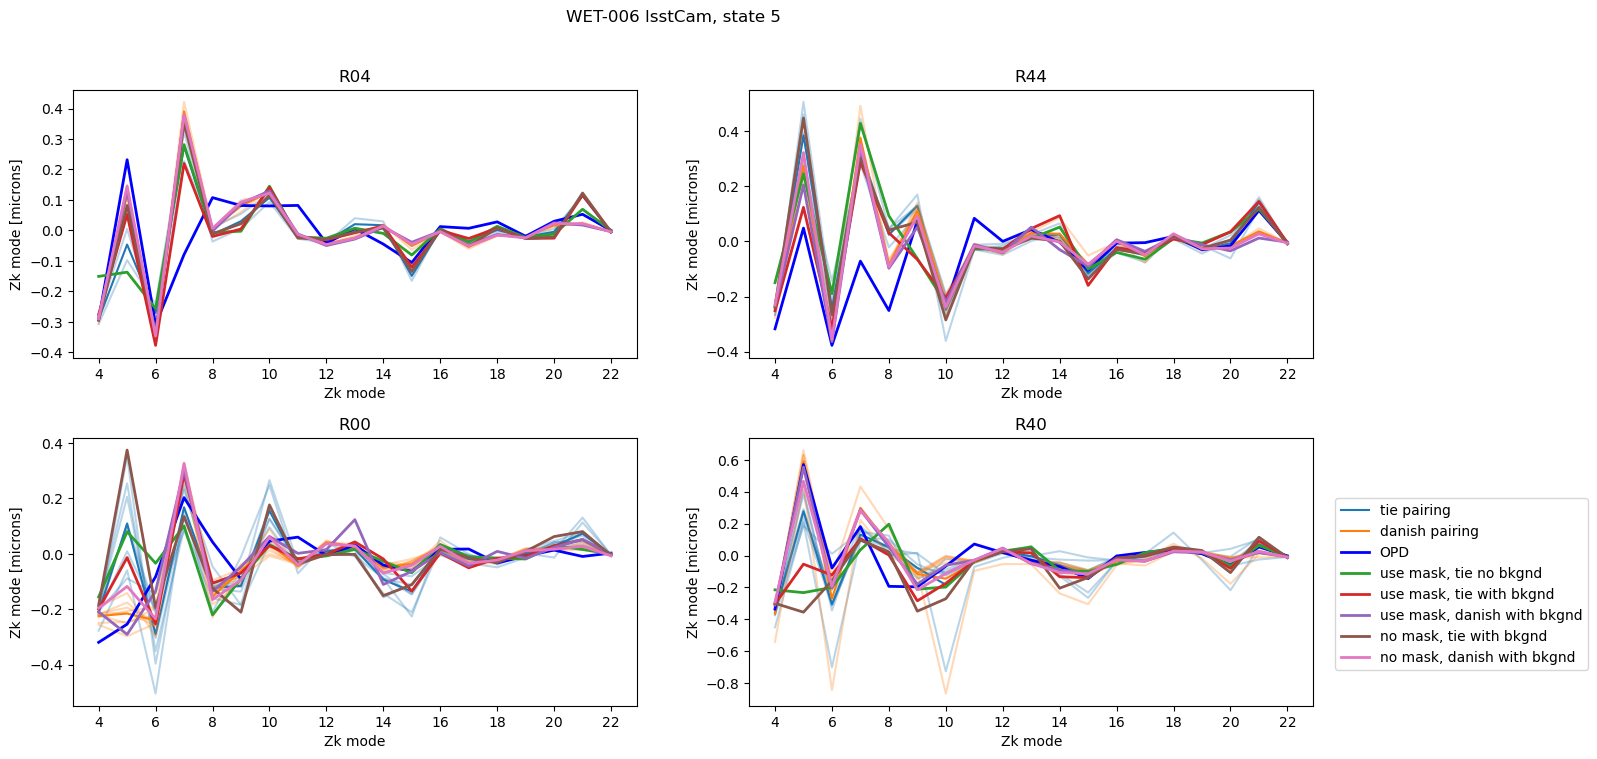

In [87]:
import matplotlib.pyplot as plt
import numpy as np
rafts = ['R04', 'R44', 'R00','R40']
state=5

cmap = cmaps['tab10']


fig,axs = plt.subplots(2,2,figsize=(16,8))
ax = np.ravel(axs)
i=0
# this plots the two sets of  results  
colors = {'danish':'green',  'tie':'orange'}

for raft in rafts:
    
    ax[i].set_title(raft )
    c=0
    for method in pairing_results.keys():
        # plot pairing  raw zks for danish and tie
        zkRaw = pairing_results[method][state][raft]
        for j in range(len(zkRaw)):
                ax[i].plot(np.arange(4,23), zkRaw[j],alpha=0.3 , 
                           c=cmap(c)
                          )
                        #c=colors[method],  )#label=method+' raw')
        # plot averaged zks for danish and tie
        ax[i].plot(np.arange(4,23), np.mean(zkRaw, axis=0), alpha=1.0 , 
                         c=cmap(c), label=f'{method.lower()} pairing')
        c+=1 

  # plot OPD
    opdId = opd_raft_to_id[raft] 
    ax[i].plot(np.arange(4,23), 0.001*np.array(all_opd[state][opdId][3:22]), label='OPD', c='blue', lw=2)
    
    ax[i].set_ylabel('Zk mode [microns]')
    ax[i].set_xlabel('Zk mode')
    ax[i].set_xticks([4,6,8,10,12,14,16,18,20,22])  
    
    i+=1

# plot stacking results
for j in stacking_results.keys():
    results = stacking_results[j]['results']
    mask_string = stacking_results[j]['mask_string']
    bkgnd_string =  stacking_results[j]['bkgnd_string']
    method =  stacking_results[j]['method']
    i=0
    
    for raft in rafts:
        
        ax[i].plot(np.arange(4,23), results[state][raft], label=f'{mask_string} mask, {method} {bkgnd_string} bkgnd',
           alpha=1.0, lw=2, c=cmap(c))
        i += 1 
    c+=1 
        
  

   
ax[3].legend(bbox_to_anchor=[1.5,0.8])

fig.subplots_adjust(hspace=0.3)
fig.suptitle(f'WET-006 lsstCam, state {state}')

In [ ]:
can keep only a few stacking results, eg TIE with / without mask:

Text(0.5, 0.98, 'WET-006 lsstCam, state 5')

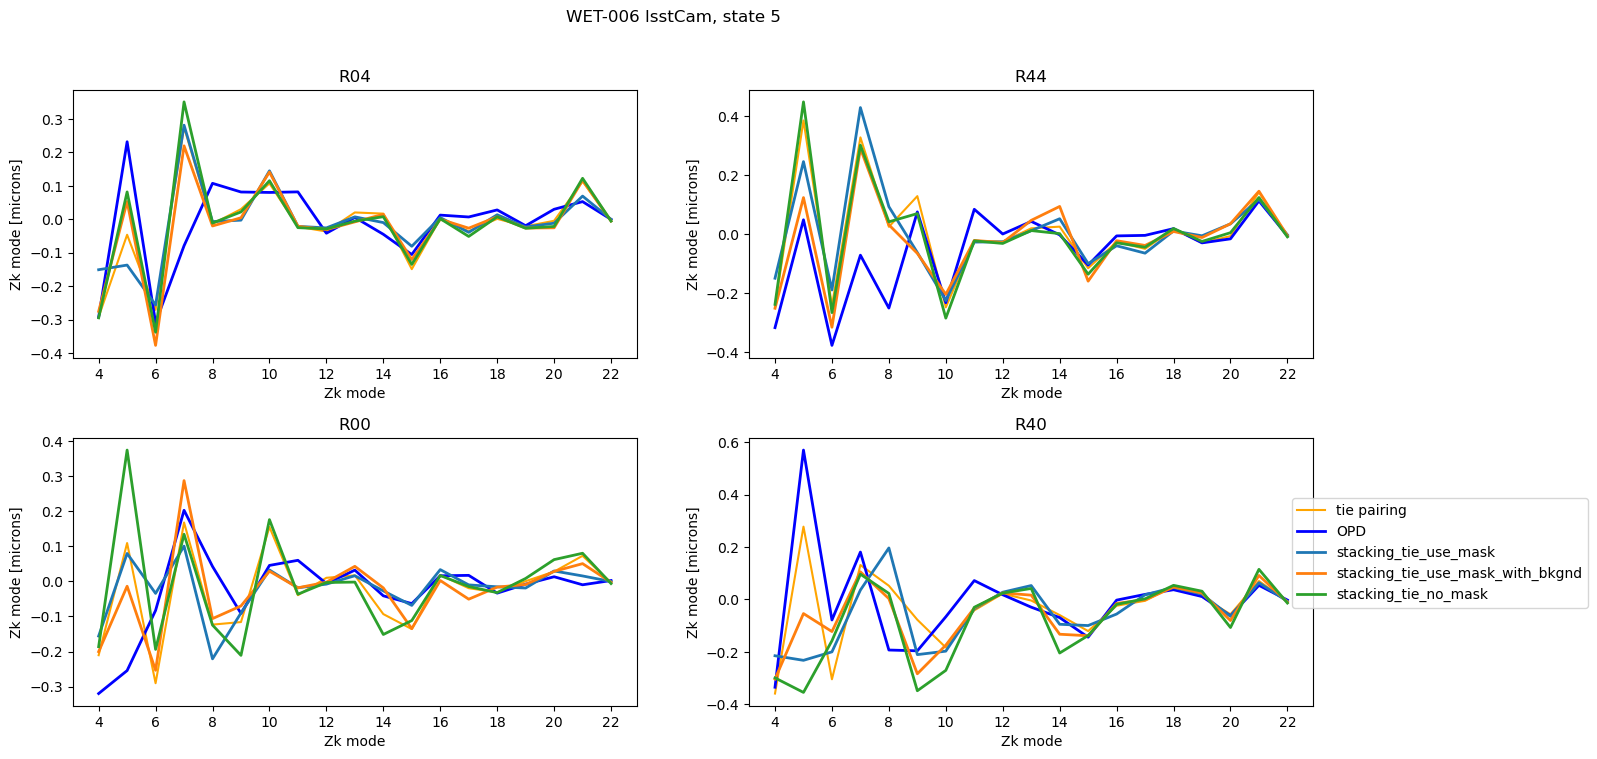

In [90]:
import matplotlib.pyplot as plt
import numpy as np
rafts = ['R04', 'R44', 'R00','R40']
state=5

fig,axs = plt.subplots(2,2,figsize=(16,8))
ax = np.ravel(axs)
i=0
# this plots the two sets of  results  
colors = {'danish':'green',  'tie':'orange'}
for raft in rafts:
    
    ax[i].set_title(raft )
    
    for method in ['tie']:#zkResults.keys():
        # plot pairing  raw zks for danish and tie
        zkRaw = pairing_results[method][state][raft]
        # for j in range(len(zkRaw)):
        #         ax[i].plot(np.arange(4,23), zkRaw[j],alpha=0.3 , 
        #                 c=colors[method],  )#label=method+' raw')
        # plot averaged zks for danish and tie
        ax[i].plot(np.arange(4,23), np.mean(zkRaw, axis=0), alpha=1.0 , 
                        c=colors[method], label=f'{method.lower()} pairing')

  # plot OPD
    opdId = opd_raft_to_id[raft] 
    ax[i].plot(np.arange(4,23), 0.001*np.array(all_opd[state][opdId][3:22]), label='OPD', c='blue', lw=2)
    
    ax[i].set_ylabel('Zk mode [microns]')
    ax[i].set_xlabel('Zk mode')
    ax[i].set_xticks([4,6,8,10,12,14,16,18,20,22])  
        
    i+=1
    
    # plot stacking results
for j in stacking_results.keys():
    results = stacking_results[j]['results']
    mask_string = stacking_results[j]['mask_string']
    bkgnd_string =  stacking_results[j]['bkgnd_string']
    method =  stacking_results[j]['method']
    method_string = stacking_results[j]['method_string']
    if 'tie' in method_string  :
        i=0
        for raft in rafts:
            
            ax[i].plot(np.arange(4,23), results[state][raft], label=f'{method_string}',
               alpha=1.0, lw=2)
            i += 1 
            
  

   
ax[3].legend(bbox_to_anchor=[1.5,0.8])

fig.subplots_adjust(hspace=0.3)
fig.suptitle(f'WET-006 lsstCam, state {state}')

Not sure if across these modes you can definitely tell... For Danish:

Text(0.5, 0.98, 'WET-006 lsstCam, state 5')

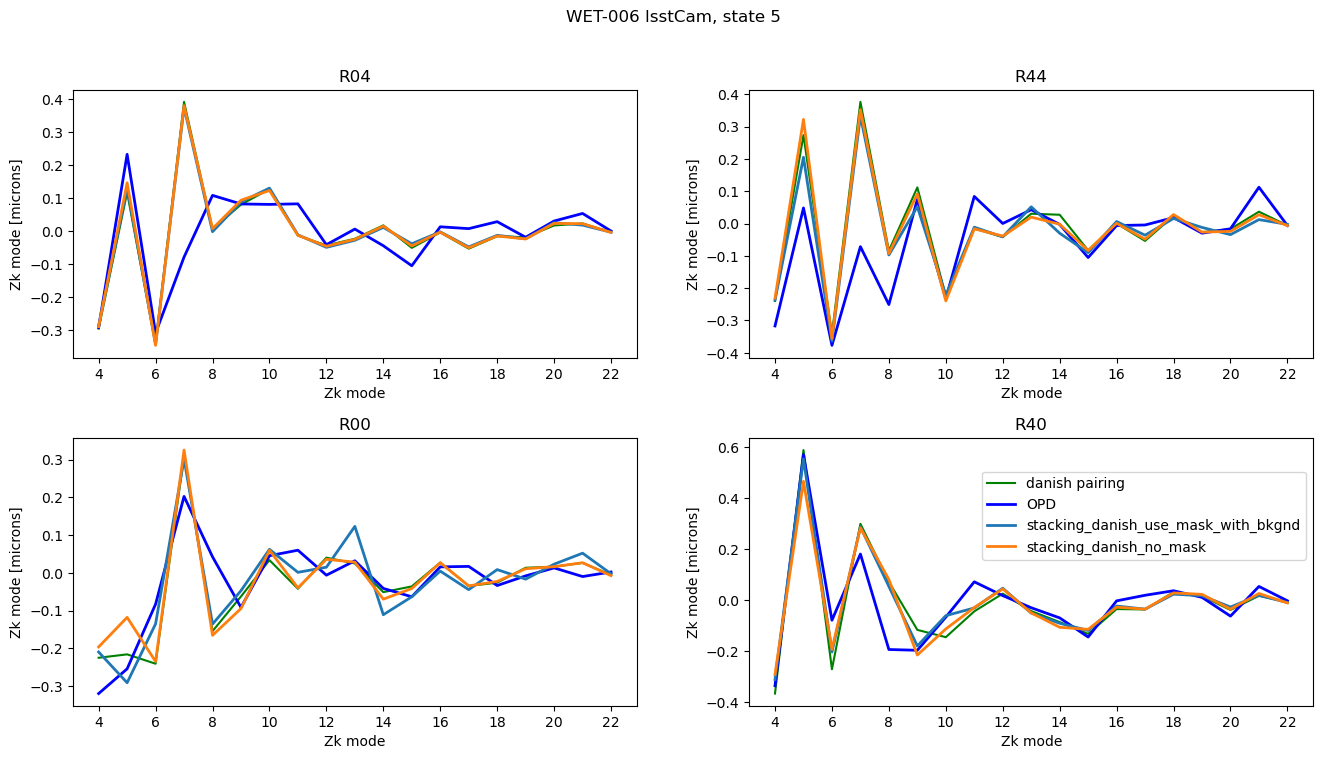

In [94]:
import matplotlib.pyplot as plt
import numpy as np
rafts = ['R04', 'R44', 'R00','R40']
state=5

fig,axs = plt.subplots(2,2,figsize=(16,8))
ax = np.ravel(axs)
i=0
# this plots the two sets of  results  
colors = {'danish':'green',  'tie':'orange'}
for raft in rafts:
    
    ax[i].set_title(raft )
    
    for method in ['danish']:#zkResults.keys():
        # plot pairing  raw zks for danish and tie
        zkRaw = pairing_results[method][state][raft]
        # for j in range(len(zkRaw)):
        #         ax[i].plot(np.arange(4,23), zkRaw[j],alpha=0.3 , 
        #                 c=colors[method],  )#label=method+' raw')
        # plot averaged zks for danish and tie
        ax[i].plot(np.arange(4,23), np.mean(zkRaw, axis=0), alpha=1.0 , 
                        c=colors[method], label=f'{method.lower()} pairing')

  # plot OPD
    opdId = opd_raft_to_id[raft] 
    ax[i].plot(np.arange(4,23), 0.001*np.array(all_opd[state][opdId][3:22]), label='OPD', c='blue', lw=2)
    
    ax[i].set_ylabel('Zk mode [microns]')
    ax[i].set_xlabel('Zk mode')
    ax[i].set_xticks([4,6,8,10,12,14,16,18,20,22])  
        
    i+=1
    
    # plot stacking results
for j in stacking_results.keys():
    results = stacking_results[j]['results']
    mask_string = stacking_results[j]['mask_string']
    bkgnd_string =  stacking_results[j]['bkgnd_string']
    method =  stacking_results[j]['method']
    method_string = stacking_results[j]['method_string']
    if 'danish' in method_string  :
        i=0
        for raft in rafts:
            
            ax[i].plot(np.arange(4,23), results[state][raft], label=f'{method_string}',
               alpha=1.0, lw=2)
            i += 1 
            
  

   
ax[3].legend(bbox_to_anchor=[1.,0.9])

fig.subplots_adjust(hspace=0.3)
fig.suptitle(f'WET-006 lsstCam, state {state}')

This shows that regardless from which type of donut it's fed (whether original background or added background) the stacking vs pairing for Danish shows allmost no difference .

## Illustrate difference between the above and the OPDs:

Text(0.5, 0.98, 'WET-006 lsstCam, state 5, \n pairing only (average of zernikeEstimateRaw) : TIE vs Danish')

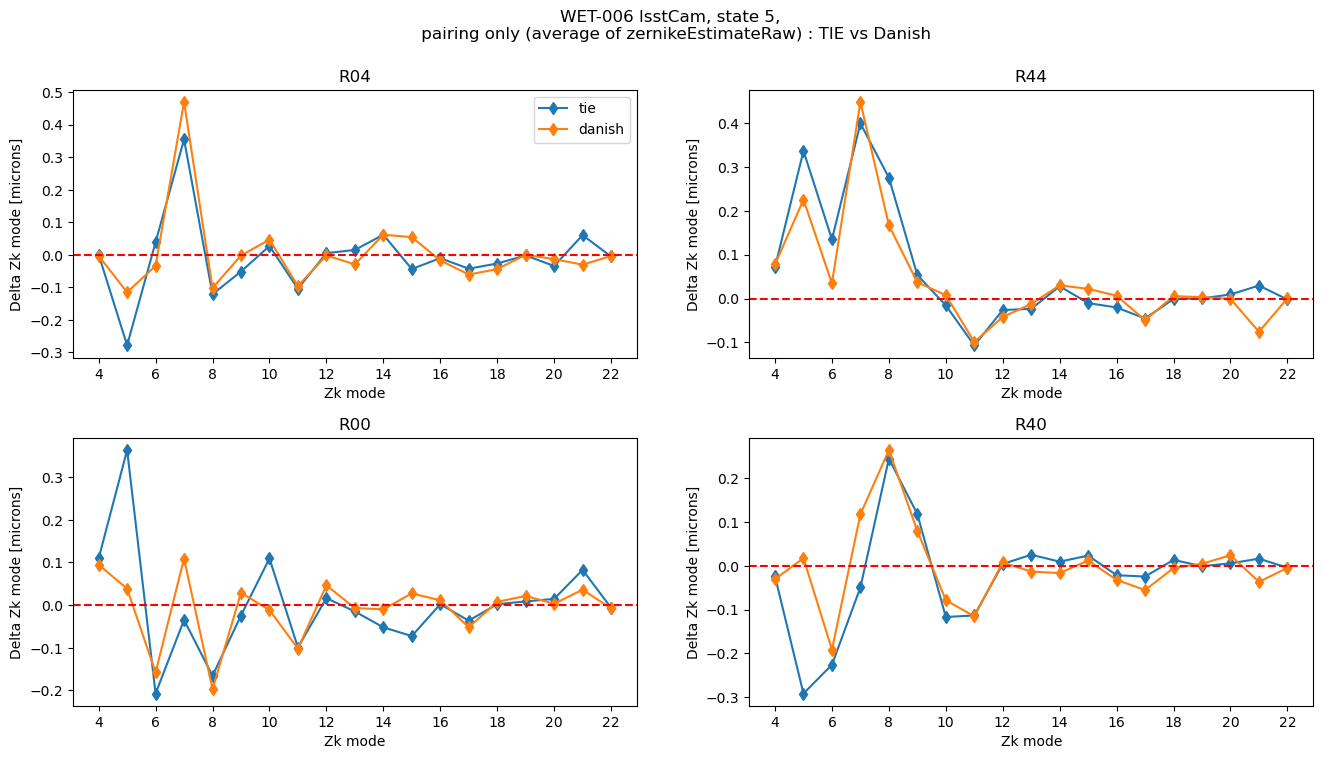

In [48]:
import matplotlib.pyplot as plt
import numpy as np
rafts = ['R04', 'R44', 'R00','R40']
state=5

fig,axs = plt.subplots(2,2,figsize=(16,8))
ax = np.ravel(axs)
i=0


# this plots  just the pairing results 
colors = {'danish':'green',  'tie':'orange'}
for raft in rafts:
    
    ax[i].set_title(raft )
    opdId = opd_raft_to_id[raft] 
    opd_zk = 0.001*np.array(all_opd[state][opdId][3:22])
    
    for method in pairing_results.keys():
        # plot pairing  raw zks for danish and tie
        zkRaw = pairing_results[method][state][raft]
        avg_zk = np.mean(zkRaw, axis=0)
     
        rms_diff_avg =  np.sqrt(np.mean(np.square(avg_zk-opd_zk)))
        ax[i].plot(np.arange(4,23), avg_zk-opd_zk, marker='d', label=f'{method}')
      
    ax[i].set_ylabel('Delta Zk mode [microns]')
    ax[i].set_xlabel('Zk mode')
    ax[i].set_xticks([4,6,8,10,12,14,16,18,20,22])
    ax[i].axhline(0,ls='--', c='red')
    
    i+=1
ax[0].legend()#bbox_to_anchor=[1.2,0.8])

fig.subplots_adjust(hspace=0.3)
fig.suptitle(f'WET-006 lsstCam, state {state}, \n pairing only (average of zernikeEstimateRaw) : TIE vs Danish')

Now also add to the mix the stacking results - this shows that overall the results are not widely different: 

Text(0.5, 0.98, 'WET-006 lsstCam, state 5, OPD-fit \n pairing vs stacking,  TIE vs Danish')

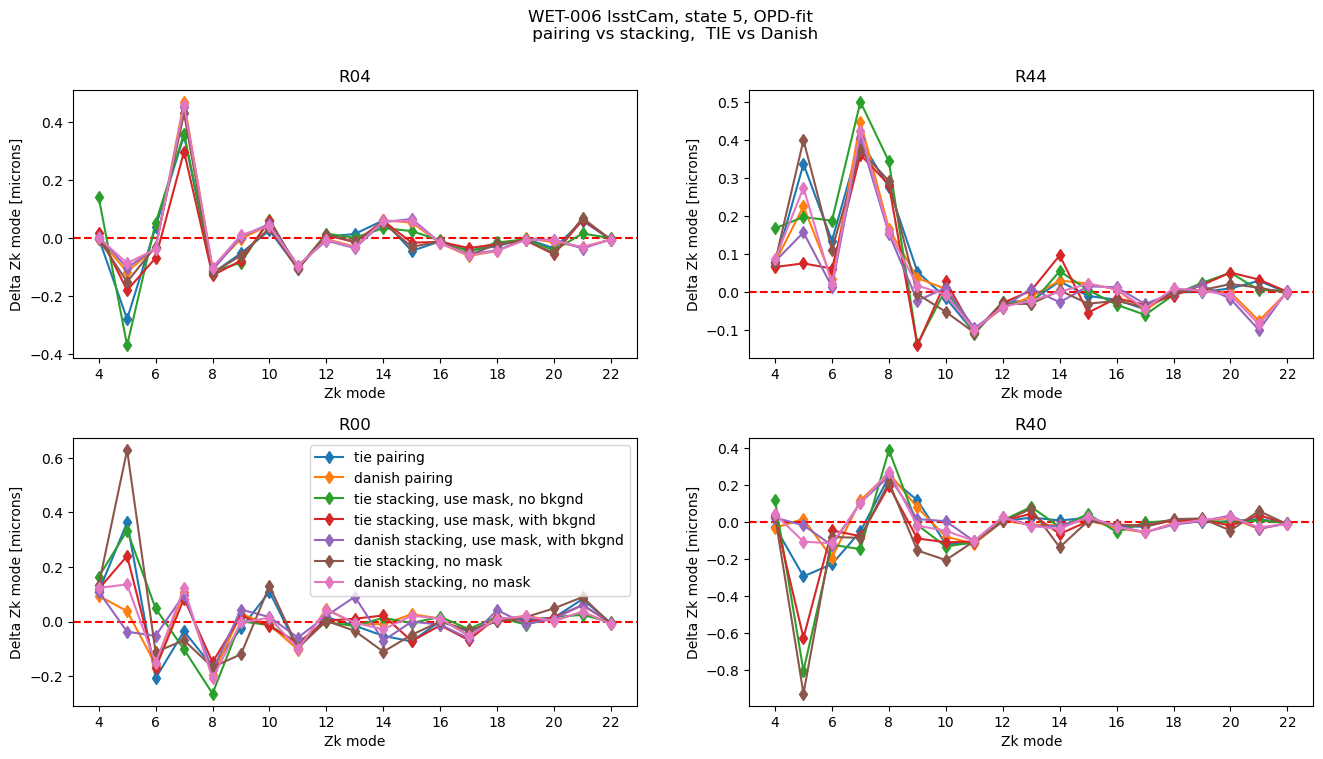

In [36]:
import matplotlib.pyplot as plt
import numpy as np
rafts = ['R04', 'R44', 'R00','R40']

state=5

fig,axs = plt.subplots(2,2,figsize=(16,8))
ax = np.ravel(axs)
i=0


# this plots  just the pairing results 
colors = {'Danish':'green',  'TIE':'orange'}
for raft in rafts:
    
    ax[i].set_title(raft )
    opdId = opd_raft_to_id[raft] 
    opd_zk = 0.001*np.array(all_opd[state][opdId][3:22])
    
    for method in pairing_results.keys():
        # plot pairing  raw zks for danish and tie
        zkRaw = pairing_results[method][state][raft]
        avg_zk = np.mean(zkRaw, axis=0)
     
        rms_diff_avg =  np.sqrt(np.mean(np.square(avg_zk-opd_zk)))
        ax[i].plot(np.arange(4,23), avg_zk-opd_zk, marker='d', label=f'{method.lower()} pairing')
      
    ax[i].set_ylabel('Delta Zk mode [microns]')
    ax[i].set_xlabel('Zk mode')
    ax[i].set_xticks([4,6,8,10,12,14,16,18,20,22])
    ax[i].axhline(0,ls='--', c='red')
    
    i+=1

# plot stacking results
for j in stacking_results.keys():
    results = stacking_results[j]['results']
    mask_string = stacking_results[j]['mask_string']
    bkgnd_string =  stacking_results[j]['bkgnd_string']
    method =  stacking_results[j]['method']
    labeladd = f'{mask_string} mask'
    if mask_string == 'use' :
        labeladd += f', {bkgnd_string} bkgnd'
        
    i=0
    for raft in rafts:
        opdId = opd_raft_to_id[raft] 
        opd_zk = 0.001*np.array(all_opd[state][opdId][3:22])
        stacked_zk = results[state][raft]
        rms_diff_stack = np.sqrt(np.mean(np.square(stacked_zk-opd_zk)))
        
        ax[i].plot(np.arange(4,23), stacked_zk-opd_zk,
                   marker='d', 
                   label=f'{method} stacking, {labeladd}')
        i += 1 
        
  

   
ax[2].legend()#bbox_to_anchor=[1.2,0.8])

fig.subplots_adjust(hspace=0.3)
fig.suptitle(f'WET-006 lsstCam, state {state}, OPD-fit \n pairing vs stacking,  TIE vs Danish')

Illustrate only the difference between pairing and stacking with mask:

Text(0.5, 0.98, 'WET-006 lsstCam, state 5, OPD-fit \n pairing vs stacking with mask : TIE vs Danish')

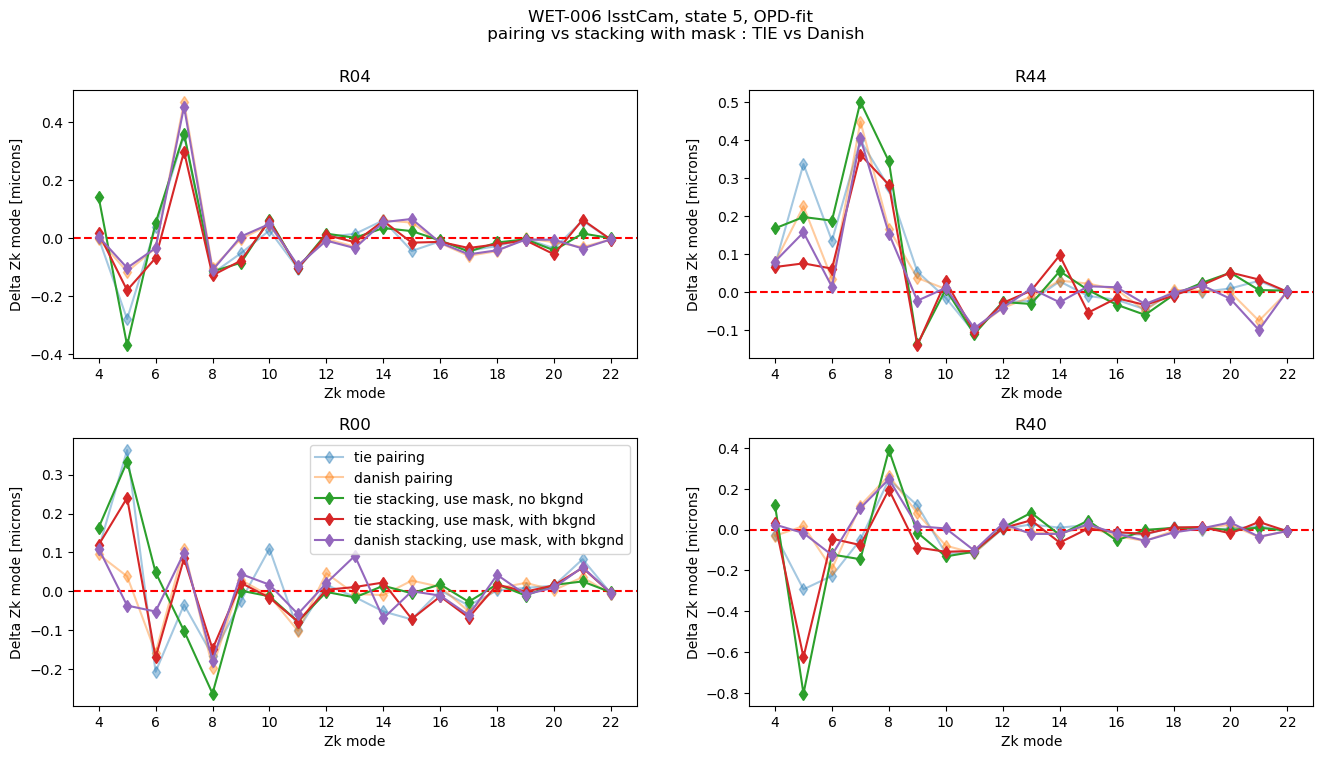

In [49]:
import matplotlib.pyplot as plt
import numpy as np
rafts = ['R04', 'R44', 'R00','R40']

state=5

fig,axs = plt.subplots(2,2,figsize=(16,8))
ax = np.ravel(axs)
i=0


# this plots  just the pairing results 
colors = {'danish':'green',  'tie':'orange'}
for raft in rafts:
    
    ax[i].set_title(raft )
    opdId = opd_raft_to_id[raft] 
    opd_zk = 0.001*np.array(all_opd[state][opdId][3:22])
    
    for method in pairing_results.keys():
        # plot pairing  raw zks for danish and tie
        zkRaw = pairing_results[method][state][raft]
        avg_zk = np.mean(zkRaw, axis=0)
     
        rms_diff_avg =  np.sqrt(np.mean(np.square(avg_zk-opd_zk)))
        ax[i].plot(np.arange(4,23), avg_zk-opd_zk, marker='d', label=f'{method.lower()} pairing',
                  alpha=0.4)
      
    ax[i].set_ylabel('Delta Zk mode [microns]')
    ax[i].set_xlabel('Zk mode')
    ax[i].set_xticks([4,6,8,10,12,14,16,18,20,22])
    ax[i].axhline(0,ls='--', c='red')
    
    i+=1

# plot stacking results
for j in stacking_results.keys():
    results = stacking_results[j]['results']
    mask_string = stacking_results[j]['mask_string']
    bkgnd_string =  stacking_results[j]['bkgnd_string']
    method =  stacking_results[j]['method']
    labeladd = f'{mask_string} mask'
    if mask_string == 'use' :
        labeladd += f', {bkgnd_string} bkgnd'
        
        i=0
        for raft in rafts:
            opdId = opd_raft_to_id[raft] 
            opd_zk = 0.001*np.array(all_opd[state][opdId][3:22])
            stacked_zk = results[state][raft]
            rms_diff_stack = np.sqrt(np.mean(np.square(stacked_zk-opd_zk)))
            
            ax[i].plot(np.arange(4,23), stacked_zk-opd_zk,
                       marker='d', 
                       label=f'{method} stacking, {labeladd}')
            i += 1 
            
  

   
ax[2].legend()#bbox_to_anchor=[1.2,0.8])

fig.subplots_adjust(hspace=0.3)
fig.suptitle(f'WET-006 lsstCam, state {state}, OPD-fit \n pairing vs stacking with mask : TIE vs Danish')

Pairing vs stacking with no mask:

Text(0.5, 0.98, 'WET-006 lsstCam, state 5, OPD-fit \n pairing vs stacking, no mask : TIE vs Danish')

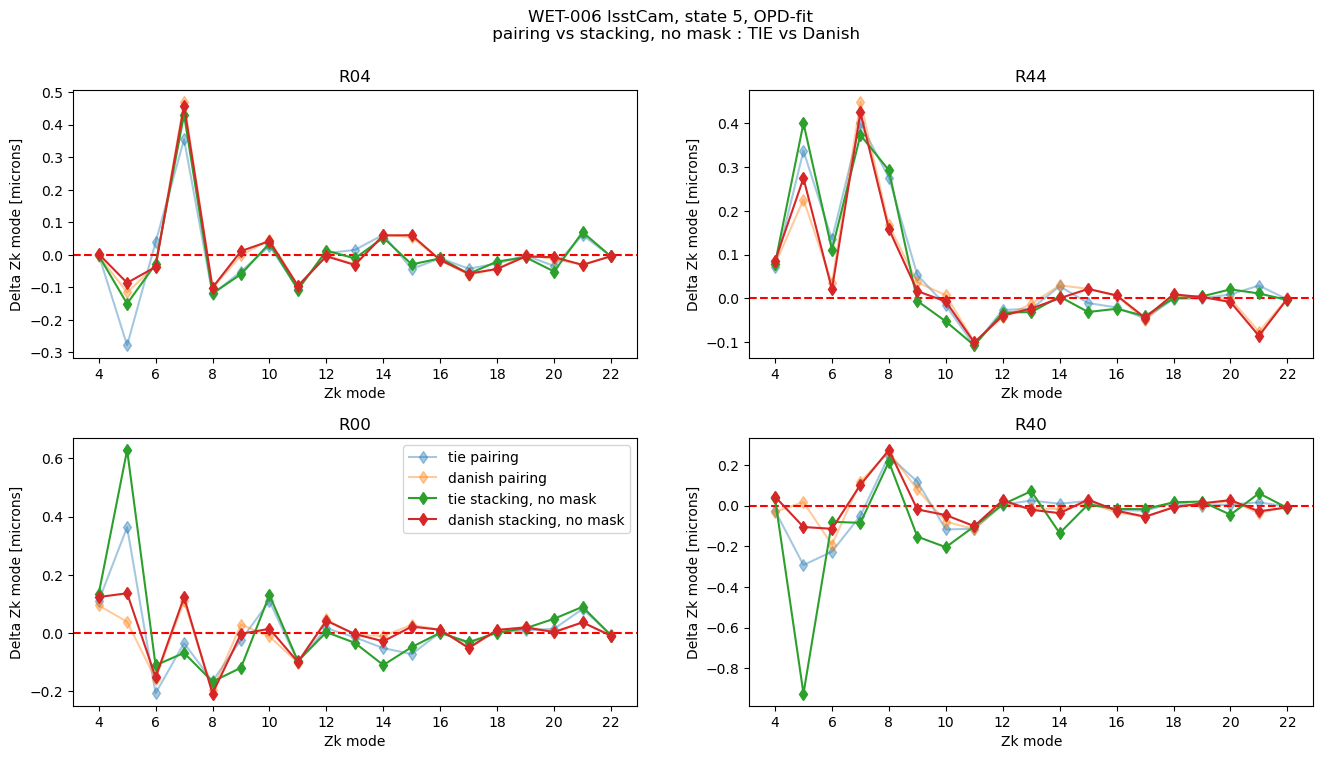

In [50]:
import matplotlib.pyplot as plt
import numpy as np
rafts = ['R04', 'R44', 'R00','R40']

state=5

fig,axs = plt.subplots(2,2,figsize=(16,8))
ax = np.ravel(axs)
i=0


# this plots  just the pairing results 
colors = {'danish':'green',  'tie':'orange'}
for raft in rafts:
    
    ax[i].set_title(raft )
    opdId = opd_raft_to_id[raft] 
    opd_zk = 0.001*np.array(all_opd[state][opdId][3:22])
    
    for method in pairing_results.keys():
        # plot pairing  raw zks for danish and tie
        zkRaw = pairing_results[method][state][raft]
        avg_zk = np.mean(zkRaw, axis=0)
     
        rms_diff_avg =  np.sqrt(np.mean(np.square(avg_zk-opd_zk)))
        ax[i].plot(np.arange(4,23), avg_zk-opd_zk, marker='d', label=f'{method.lower()} pairing',
                  alpha=0.4)
      
    ax[i].set_ylabel('Delta Zk mode [microns]')
    ax[i].set_xlabel('Zk mode')
    ax[i].set_xticks([4,6,8,10,12,14,16,18,20,22])
    ax[i].axhline(0,ls='--', c='red')
    
    i+=1

# plot stacking results
for j in stacking_results.keys():
    results = stacking_results[j]['results']
    mask_string = stacking_results[j]['mask_string']
    bkgnd_string =  stacking_results[j]['bkgnd_string']
    method =  stacking_results[j]['method']
    labeladd = f'{mask_string} mask'
    if mask_string == 'use' :
        labeladd += f', {bkgnd_string} bkgnd'
    else:  
        i=0
        for raft in rafts:
            opdId = opd_raft_to_id[raft] 
            opd_zk = 0.001*np.array(all_opd[state][opdId][3:22])
            stacked_zk = results[state][raft]
            rms_diff_stack = np.sqrt(np.mean(np.square(stacked_zk-opd_zk)))
            
            ax[i].plot(np.arange(4,23), stacked_zk-opd_zk,
                       marker='d', 
                       label=f'{method} stacking, {labeladd}')
            i += 1 
            
  

   
ax[2].legend()#bbox_to_anchor=[1.2,0.8])

fig.subplots_adjust(hspace=0.3)
fig.suptitle(f'WET-006 lsstCam, state {state}, OPD-fit \n pairing vs stacking, no mask : TIE vs Danish')

In [61]:
#stacking_results[method]

## Illustrate differences from OPD for a particular state

Text(0.5, 0.98, 'WET-006 lsstCam, state 5, RMS difference (fit - OPD) ')

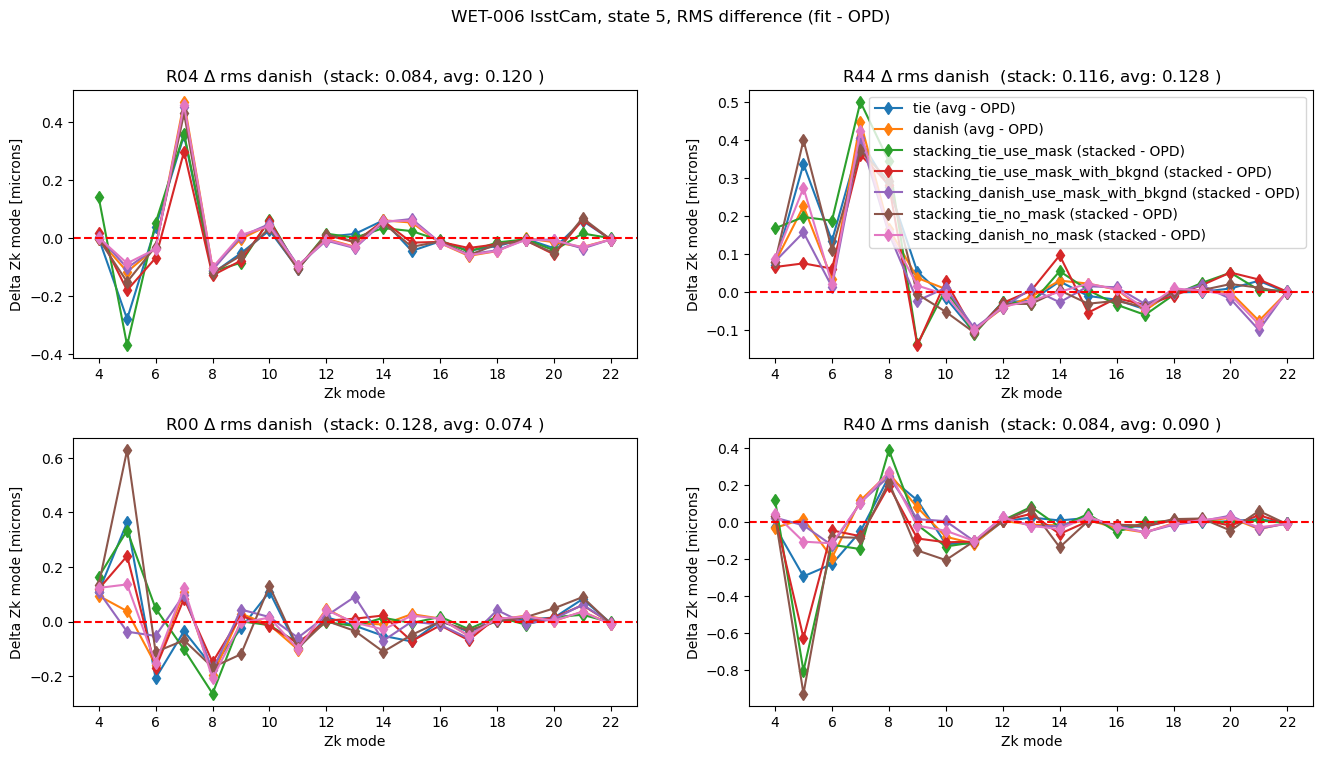

In [68]:
import matplotlib.pyplot as plt
import numpy as np
rafts = ['R04', 'R44', 'R00','R40']
state=5

fig,axs = plt.subplots(2,2,figsize=(16,8))
ax = np.ravel(axs)
i=0
# this plots the two sets of  results  
colors = {'danish':'green',  'tie':'orange'}
for raft in rafts:
    
    ax[i].set_title(raft )

    # get OPD for that raft 
    opdId = opd_raft_to_id[raft] 
    opd_zk = 0.001*np.array(all_opd[state][opdId][3:22])
    
    for method in pairing_results.keys():
        zkRaw = pairing_results[method][state][raft]
        avg_zk = np.mean(zkRaw, axis=0)
        rms_diff_avg =  np.sqrt(np.mean(np.square(avg_zk-opd_zk)))
        ax[i].set_title(f'{raft} '+r'$\Delta$ rms '+\
                        f'{method}  (stack: {rms_diff_stack:.3f}, ' +\
                        f'avg: {rms_diff_avg:.3f} )')
        ax[i].plot(np.arange(4,23), avg_zk-opd_zk, marker='d',
                   label=f'{method} (avg - OPD)')
     
    for method in stacking_results.keys():
         stacked_zk = stacking_results[method]['results'][state][raft]
         label =  stacking_results[method]['method_string']
         rms_diff_stack = np.sqrt(np.mean(np.square(stacked_zk-opd_zk)))
         ax[i].plot(np.arange(4,23), stacked_zk-opd_zk, marker='d',
                   label=f'{label} (stacked - OPD)')


    ax[i].set_ylabel('Delta Zk mode [microns]')
    ax[i].set_xlabel('Zk mode')
    ax[i].set_xticks([4,6,8,10,12,14,16,18,20,22])
    ax[i].axhline(0,ls='--', c='red')
    
    i+=1
ax[1].legend()

fig.subplots_adjust(hspace=0.3)
fig.suptitle(f'WET-006 lsstCam, state {state}, RMS difference (fit - OPD) ')

## Summarize these differences as a function of states

In [9]:
# Pairing results
method = 'TIE'
pairing_results[method][state][raft]

array([[-0.34117482,  0.68533198, -0.50454304,  0.30660415,  0.06451737,
         0.22561785, -0.15289213, -0.00716999,  0.00999779,  0.07249031,
         0.06065582, -0.20561294, -0.0139304 , -0.04584068,  0.05473097,
        -0.03029758,  0.0872166 ,  0.12333601, -0.01258154],
       [-0.33869457,  0.80555095, -0.55410106,  0.30819186,  0.03377598,
         0.27655156, -0.18408819,  0.00702791,  0.02455909,  0.07320439,
         0.03526863, -0.24546014, -0.00926945, -0.05109933,  0.04191079,
        -0.02958258,  0.11418975,  0.09322762, -0.01222426],
       [-0.3293717 ,  0.64516343, -0.484421  ,  0.30693416,  0.06905757,
         0.15983665, -0.12667374, -0.00629463,  0.00514988,  0.08949863,
         0.08888939, -0.21790765, -0.01669593, -0.04290607,  0.04349042,
        -0.02941146,  0.10879573,  0.12674672, -0.01186401],
       [-0.31184917,  0.73875801, -0.34378653,  0.44754755,  0.11442042,
         0.23209474, -0.25922391,  0.0058457 , -0.02621462,  0.1035612 ,
         0.140

In [74]:
# This is keyed only on 'method', i.e.  'algo' : 
pairing_results.keys()

dict_keys(['tie', 'danish'])

In [75]:
rafts = ['R04', 'R44', 'R00','R40']

rmss={}

# add stacking results 
for j in stacking_results.keys():
    results = stacking_results[j]['results']
    mask_string = stacking_results[j]['mask_string']
    bkgnd_string =  stacking_results[j]['bkgnd_string']
    method =  stacking_results[j]['method']
    method_string = f'stacking_{method}_{mask_string}_mask'
   
    if mask_string == 'use' :
        method_string += f'_{bkgnd_string}_bkgnd'
    print(method_string)
   # else:  
       # i=0
    #method+='_stacking_'
    rmss[method_string] = {}
    for raft in rafts:
        rmss[method_string][raft] = []
        opdId = opd_raft_to_id[raft] 
        
        for state in range(1,101):
            
            opd_zk = 0.001*np.array(all_opd[state][opdId][3:22])
    
            stacked_zk = results[state][raft]
            rms_diff = np.sqrt(np.mean(np.square(stacked_zk-opd_zk)))


            rmss[method_string][raft].append(rms_diff)

# add pairing results 
for algo in pairing_results.keys():
   method_string = f'pairing_{algo}'
   rmss[method_string] = {}
   print(method_string)
   for raft in rafts:
       rmss[method_string][raft] = []
       opdId = opd_raft_to_id[raft] 
       
       for state in range(1,101):
            opd_zk = 0.001*np.array(all_opd[state][opdId][3:22])
            avg_zk = np.mean(pairing_results[algo][state][raft], axis=0)
            rms_diff =  np.sqrt(np.mean(np.square(avg_zk-opd_zk)))
            rmss[method_string][raft].append(rms_diff)

stacking_tie_use_mask_no_bkgnd
stacking_tie_use_mask_with_bkgnd
stacking_danish_use_mask_with_bkgnd
stacking_tie_no_mask
stacking_danish_no_mask
pairing_tie
pairing_danish


In [76]:
for method in rmss.keys():
    print(method)# rmss[method][raft]

stacking_tie_use_mask_no_bkgnd
stacking_tie_use_mask_with_bkgnd
stacking_danish_use_mask_with_bkgnd
stacking_tie_no_mask
stacking_danish_no_mask
pairing_tie
pairing_danish


In [16]:
#rmss[method][raft]

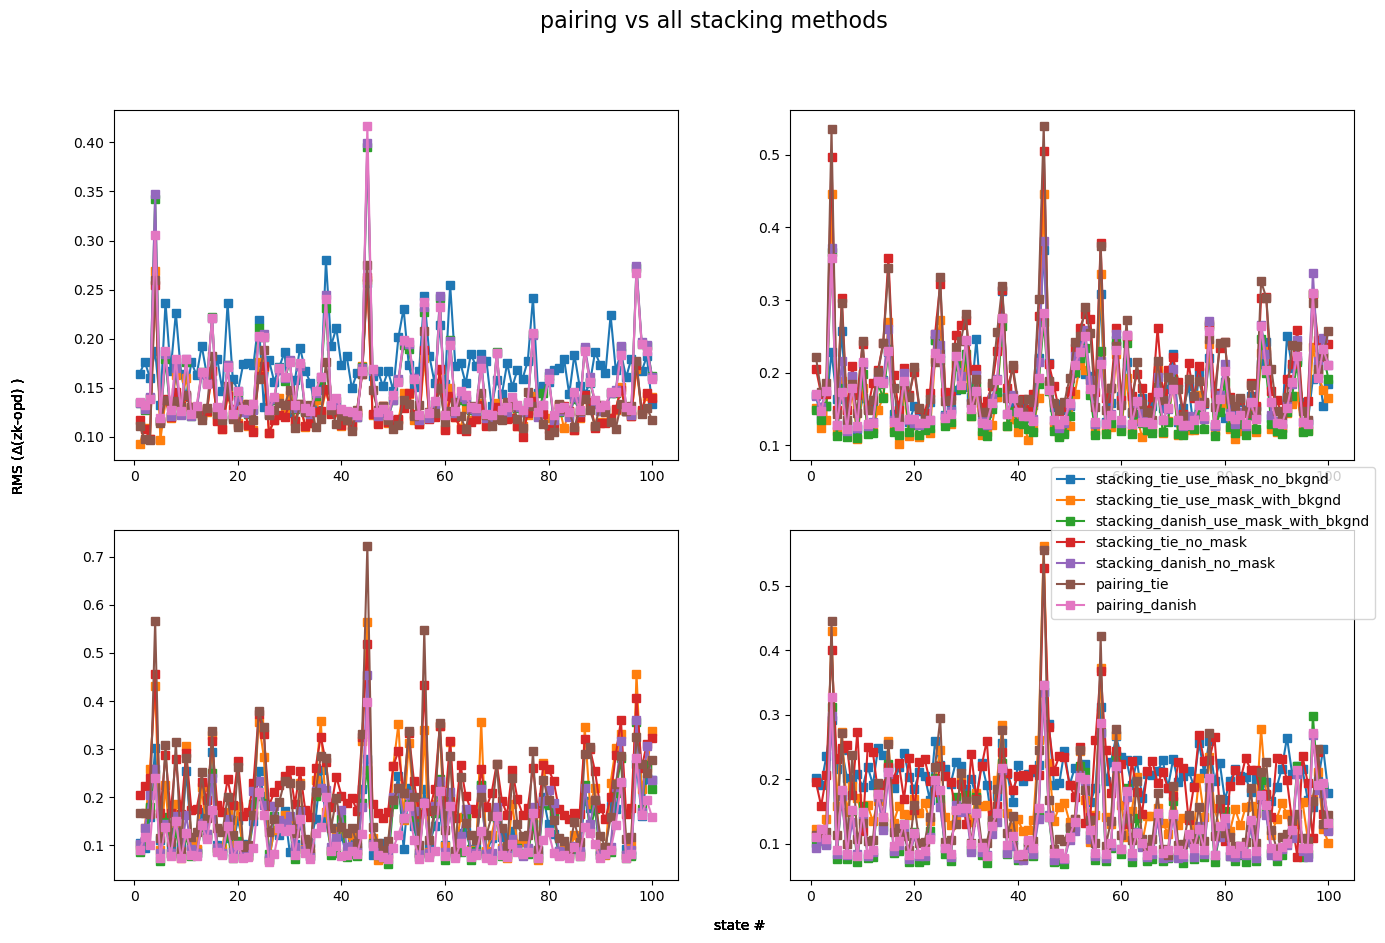

In [77]:
rafts = ['R04', 'R44', 'R00','R40']

fig,axs = plt.subplots(2,2,figsize=(16,10))
ax = np.ravel(axs)

for method in rmss.keys():

    i=0
    
    for raft in rafts:
        ax[i].plot(np.arange(1,101), rmss[method][raft], marker='s', label=f'{method}')
        
        i+=1
    
    fig.text(0.5,0.06,'state #')
    fig.text(0.06,0.5,r'RMS ($\Delta$(zk-opd) ) ', rotation=90)
fig.suptitle('pairing vs all stacking methods', fontsize=16)
ax[3].legend(bbox_to_anchor=[1.05,1.2])

It's a bit hard to say which of these is advantageous, but  I don't think either is. 

### Marginalize across states:  

Try to calculate the mean RMS difference across all states per detector per method... 

In [72]:
from matplotlib import colormaps as cmaps
from astropy.table import Table

means_arr = []
rafts_arr = []
methods_arr = []
rafts = ['R04', 'R44', 'R00','R40']
for raft in rafts:
    #means[raft] =
    for method in rmss.keys():
        mean_rms = np.median( rmss[method][raft]) 
        #print(raft, mean_rms, f'{method}')
        means_arr.append(mean_rms)
        rafts_arr.append(raft)
        methods_arr.append(method)
    #print('\n')
mean_rms_table = Table(data=[means_arr, rafts_arr, methods_arr], names=['mean_rms', 'raft', 'method'])

In [103]:
for raft in rafts:
    per_raft = mean_rms_table[mean_rms_table['raft'] == raft]# .sort('mean_rms')
    per_raft.sort('mean_rms')
    print(per_raft)

      mean_rms      raft                method              
------------------- ---- -----------------------------------
0.12245982433194912  R04    stacking_tie_use_mask_with_bkgnd
0.12287115478025104  R04                stacking_tie_no_mask
 0.1272135180411988  R04                         pairing_TIE
 0.1337388102052313  R04             stacking_danish_no_mask
 0.1342364041823671  R04 stacking_danish_use_mask_with_bkgnd
0.13711868256738124  R04                      pairing_Danish
0.16788752144434005  R04      stacking_tie_use_mask_no_bkgnd
      mean_rms      raft                method              
------------------- ---- -----------------------------------
0.13367654248935212  R44 stacking_danish_use_mask_with_bkgnd
0.13394723071818743  R44    stacking_tie_use_mask_with_bkgnd
0.15050260405928126  R44                      pairing_Danish
 0.1521178698309197  R44             stacking_danish_no_mask
 0.1597151828776096  R44      stacking_tie_use_mask_no_bkgnd
 0.1836104280153719  R44

Summarize the results across all rafts, i.e. calculate the mean rms per state:

In [105]:
#rmss[method_string][raft]

In [100]:
rmss_marginalized = {}
for method in rmss.keys():
    rmss_marginalized[method] = {}

    rmss_marginalized  rmss[method_string][raft]

mean_rms,raft,method
float64,str3,str35
0.11456853669153468,R00,pairing_Danish
0.13179846853460636,R00,stacking_danish_use_mask_with_bkgnd
0.13870819999884276,R00,stacking_tie_use_mask_no_bkgnd
0.1442100890599692,R00,stacking_danish_no_mask
0.17382747593714268,R00,stacking_tie_use_mask_with_bkgnd
0.1954816505055751,R00,pairing_TIE
0.2325540575094099,R00,stacking_tie_no_mask


In [98]:
mean_rms_table

mean_rms,raft,method
float64,str3,str35
0.17374791703244463,R04,stacking_tie_use_mask_no_bkgnd
0.12957704731225278,R04,stacking_tie_use_mask_with_bkgnd
0.15289969100464137,R04,stacking_danish_use_mask_with_bkgnd
0.1284031637639516,R04,stacking_tie_no_mask
0.15343726984083206,R04,stacking_danish_no_mask
0.13107332880739597,R04,pairing_TIE
0.15480531551381804,R04,pairing_Danish
0.17573624864289494,R44,stacking_tie_use_mask_no_bkgnd
0.15877921386567193,R44,stacking_tie_use_mask_with_bkgnd


### Marginalize across detectors

summarize the RMS difference between each method taking the average per four sensors

In [78]:

mean_per_state = {}
for method in rmss.keys():
    all_raft_data = []
    for raft in rafts:
        all_raft_data.append( rmss[method][raft])
    mean_per_state[method] = np.mean(all_raft_data,axis=0)

Plot per state: 

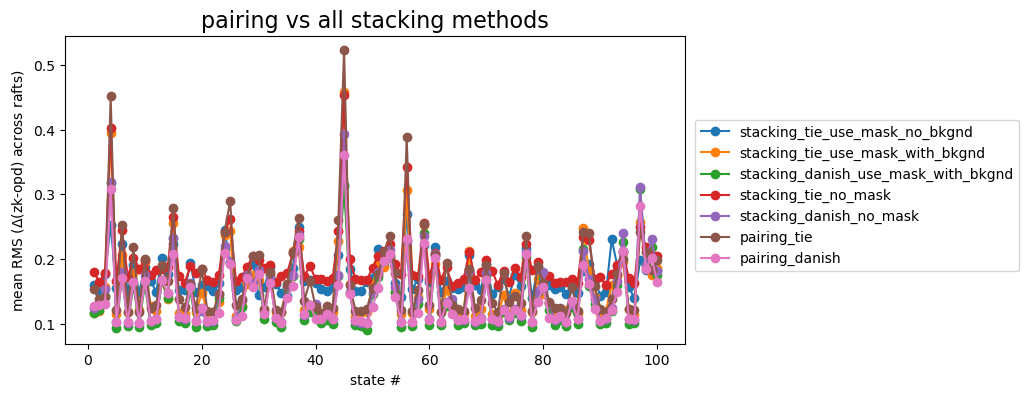

In [79]:
import matplotlib.pyplot as plt 
from matplotlib import colormaps as cmaps
rafts = ['R04', 'R44', 'R00','R40']
cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(8,4))
j=0
for method in mean_per_state.keys():
    
    ax.plot(np.arange(1,101), mean_per_state[method], marker='o', label=f'{method}',
           c=cmap(j))
    j+=1
      
ax.set_xlabel('state #')
ax.set_ylabel(r'mean RMS ($\Delta$(zk-opd) across rafts) ',)
ax.set_title('pairing vs all stacking methods', fontsize=16)
ax.legend(bbox_to_anchor=[1.55,0.75])

Show just the two pairing method: which overall produces results closer to the OPD:

In [80]:
mean_per_state.keys()

dict_keys(['stacking_tie_use_mask_no_bkgnd', 'stacking_tie_use_mask_with_bkgnd', 'stacking_danish_use_mask_with_bkgnd', 'stacking_tie_no_mask', 'stacking_danish_no_mask', 'pairing_tie', 'pairing_danish'])

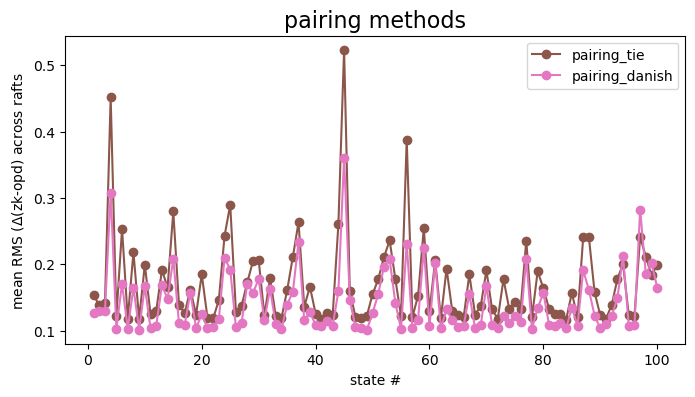

In [81]:
import matplotlib.pyplot as plt 
rafts = ['R04', 'R44', 'R00','R40']

fig,ax = plt.subplots(1,1,figsize=(8,4))
cmap = cmaps['tab10']
j=0
for method in mean_per_state.keys():
    if method.startswith('pairing'):
        ax.plot(np.arange(1,101), mean_per_state[method], marker='o', label=f'{method}', c=cmap(j))
    j +=1 
ax.set_xlabel('state #')
ax.set_ylabel(r'mean RMS ($\Delta$(zk-opd) across rafts ',)
ax.set_title('pairing methods', fontsize=16)
ax.legend()#bbox_to_anchor=[1.55,0.75])

We see that overall Danish has better results (closer to the OPD) than TIE. 

Most stacking results are not as good as pairing for  Danish:

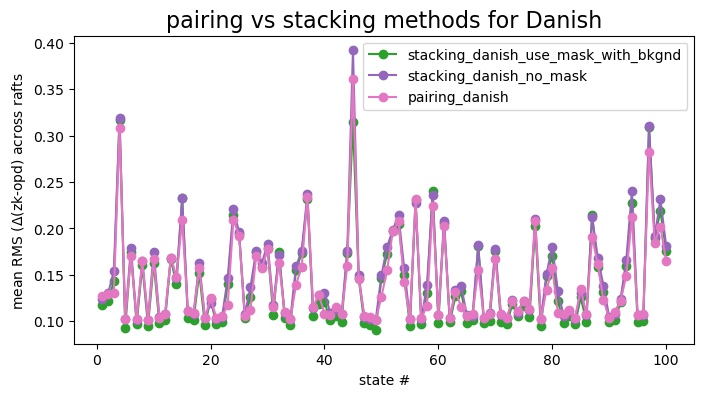

In [82]:
import matplotlib.pyplot as plt 
rafts = ['R04', 'R44', 'R00','R40']

fig,ax = plt.subplots(1,1,figsize=(8,4))
cmap = cmaps['tab10']
j=0
for method in mean_per_state.keys():
    if 'danish' in method:
        ax.plot(np.arange(1,101), mean_per_state[method], marker='o', label=f'{method}', c=cmap(j))
    j +=1 
ax.set_xlabel('state #')
ax.set_ylabel(r'mean RMS ($\Delta$(zk-opd) across rafts ',)
ax.set_title('pairing vs stacking methods for Danish', fontsize=16)
ax.legend()#bbox_to_anchor=[1.55,0.75])

And as for TIE:

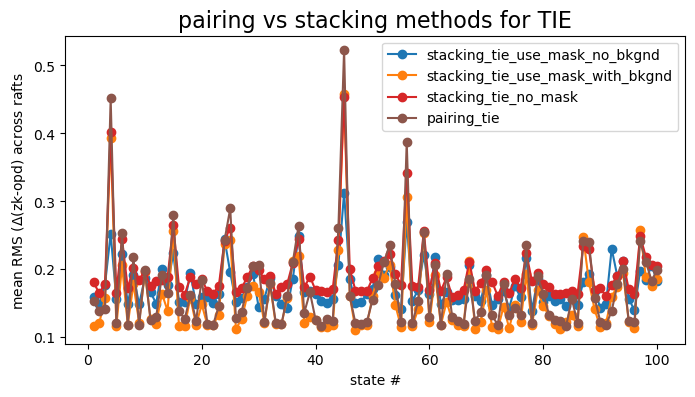

In [83]:
import matplotlib.pyplot as plt 
rafts = ['R04', 'R44', 'R00','R40']

fig,ax = plt.subplots(1,1,figsize=(8,4))
cmap = cmaps['tab10']
j=0
for method in mean_per_state.keys():
    if 'tie' in method:
        ax.plot(np.arange(1,101), mean_per_state[method], marker='o', label=f'{method}', c=cmap(j))
    j +=1 
ax.set_xlabel('state #')
ax.set_ylabel(r'mean RMS ($\Delta$(zk-opd) across rafts ',)
ax.set_title('pairing vs stacking methods for TIE', fontsize=16)
ax.legend()#bbox_to_anchor=[1.55,0.75])

## Illustrate different choices for stacking:

In [3]:
def stack_donut_wep_im_refactor(donutStamps,  N =2,  indices = None, pixel_stack = 'mean' ,
                     use_mask = False, replace_zeros_with_nans = True, after_avg_fill_with_bkgnd= True ):
        
    stacked = {}
    
    if indices is None:
        indices = np.arange(N)
        
    else:
        N = len(indices)
        
    stacked['N'] = N
    stacked['indices'] = indices
        
    # create updated donut stamps consisting of the stacked images
    
    # initialize empty arrays of the correct dimension
    image_stack = []
    bkgnd_stack = [] 
    
    # add donut image arrays, store the x,y 
    xs = []
    ys = []
    
   
    j = 0 
    for i in indices:
        #print(f'stacking {i}')
        stamp = donutStamps[i]
        image = stamp.stamp_im.image.array
         
        if use_mask:
            mask = stamp.stamp_im.mask.array  # has values like 0, 1024,  2048 etc 
            binary_mask = np.array(mask>0).astype(int)  # has values 0 or 1 
            arr = image * binary_mask
            if replace_zeros_with_nans:
                arr[arr==0] = np.nan  # replace zeros with NaNs 
        else:
            arr = image
        
        image_stack.append(arr)
        bkgnd_stack.append(image)
        
        # that already transposes each field angle ... 
        fieldxy = stamp.calcFieldXY()[::-1]
        xs.append(fieldxy[0])
        ys.append(fieldxy[1])
        
        j += 1 
    
    
        #print('stacked: ', indices)
        # store the original fieldXY 
        stacked['fieldX'] = xs
        stacked['fieldY'] = ys
        
    # store the stacked image
    if pixel_stack == 'sum':
        donutStackedArray = np.sum(image_stack, axis=0)
    elif pixel_stack == 'mean':
        donutStackedArray = np.mean(image_stack, axis=0)
    elif pixel_stack == 'nanmean':
        donutStackedArray = np.nanmean(image_stack, axis=0)
        bkgndMean = np.nanmean(bkgnd_stack, axis=0)

    # replace np.nan with mean background...
    if use_mask and after_avg_fill_with_bkgnd:

        # change interval (0,1) to (-0.5,0.5) , and decrease to very small value
        #bkgnd = 0.1*(np.random.random_sample(size=np.shape(donutStackedArray))-0.5)    
        mask_nans = np.isnan(donutStackedArray)
        #donutStackedArray[mask_nans] = bkgnd[mask_nans]
        donutStackedArray[mask_nans] = bkgndMean[mask_nans]
    

    stacked['donutStackedArray'] = donutStackedArray
    
    # find the midpoint fieldXY coordinates
    # average in the same way x and y coordinates 
    # for the intra and extra donut alike
    # treat them as already transposed
    stacked['fieldXmean'] = np.mean(xs)
    stacked['fieldYmean'] = np.mean(ys)
    
    # store information on how pixels were combined 
    stacked['pixelStack'] = pixel_stack


    # part of _setWepImage(self):
    """Return a ts.wep.image.Image object for the stamp.

    Note that the information from the butler is in the data visualization
    coordinate system (DVCS), but the WEP Image is in the global camera
    coordinate system (CCS). These coordinate systems are related by a
    transpose. See sitcomtn-003.lsst.io for more information.

    Furthermore, CWFS images that arrive from the butler are rotated with
    respect to the science sensors. The info in the WEP Images has been
    de-rotated so that everything aligns with the global coordinate system
    used by the science sensors.
    """
    # both the camera name and the detector would be all
    # identical for all stamps in here ,
    # hence it would be the same Euler angle 
    
    # stamp.cam_name  yields eg. LSSTCam;
    # taking it from the stamp 
    # allows to stack also images from LSSTComCam,  or FAM ... 
    camera = getCameraFromButlerName(stamp.cam_name)
     
    detector = camera.get(stamp.detector_name)

    # Get the rotation with respect to the science sensors
    eulerZ = -detector.getOrientation().getYaw().asDegrees()
    nRot = int(eulerZ // 90)
    if not np.isclose(eulerZ % 90, 0):
        raise RuntimeError(
            f"The detector is rotated {-eulerZ} deg with respect to the science "
            "sensors, but _setWepImage() only works for sensors whose rotations "
            "are an integer multiple of 90 deg."
        )

    # Rotate to orientation of science sensors
    image = np.rot90(donutStackedArray, nRot)

    # Transpose the image (DVCS -> CCS)
    image = image.T

    # Get the field angle, and transpose (DVCS -> CCS)
    #fieldAngle = stamp.calcFieldXY()
    # the x,y are already a transpose of calcFieldXY() above 
    fieldAngle = (stacked['fieldXmean'], stacked['fieldYmean'])

    # Determine the blend offsets
    if stamp.blend_centroid_positions.size > 0:
        # Get the offsets in the original pixel coordinates
        blendOffsets = stamp.blend_centroid_positions - stamp.centroid_position

        # Rotate the coordinates (by -90 each time)
        # to match the science sensors
        rotMat = np.array([[0, 1], [-1, 0]])
        if stamp.defocal_type == "extra":
            rotMat = np.linalg.matrix_power(rotMat, nRot + 2)
        else:
            rotMat = np.linalg.matrix_power(rotMat, nRot)
        blendOffsets = np.transpose(rotMat @ blendOffsets.T)

    else:
        blendOffsets = None

    # Package everything in an Image object
    wepImage = Image(
        image=image,
        fieldAngle=fieldAngle,
        defocalType=stamp.defocal_type,
        bandLabel=stamp.bandpass,
        blendOffsets=blendOffsets,
    )

    stacked['wep_im'] = wepImage
    

    return stacked

In [45]:
#for ref in refs:
#    print(ref.dataId.detector.id, ref.dataId.detector.raft)

/tmp/ipykernel_45618/2484528427.py:63: RuntimeWarning: Mean of empty slice
  donutStackedArray = np.nanmean(image_stack, axis=0)


Text(0.5, 0.98, 'state 2, detector R44')

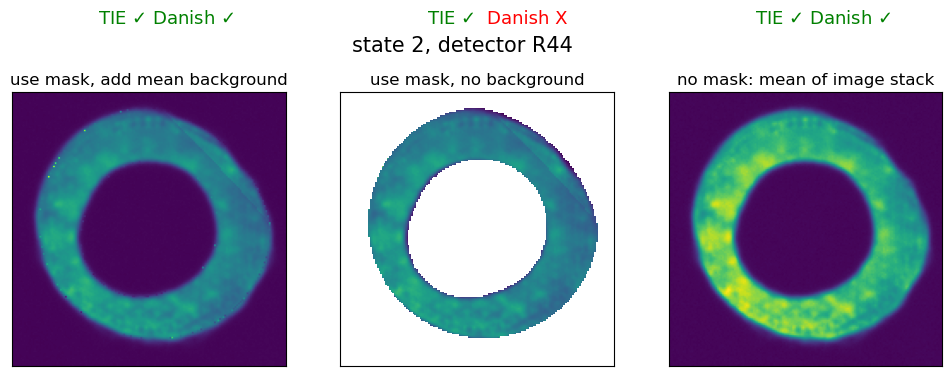

In [12]:
from lsst.daf import butler as dafButler

import matplotlib.pyplot as plt
import numpy as np

from lsst.ts.wep.utils import (
    WfAlgorithmName,
    getTaskInstrument,
    getCameraFromButlerName
)

from lsst.ts.wep.image import Image

butlerRootPath = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo'
output_collection = 'all_states_direct_stamps'

butler = dafButler.Butler(butlerRootPath)
# registry = butler.registry

# datasetRefs = registry.queryDatasets('donutStampsExtra', collections=[output_collection],
#                                      where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded()

# print(len(list(datasetRefs)))
# refs = []
# for ref in datasetRefs:
#     refs.append(ref)

# ref = refs[1]

# state = int(str(ref.dataId.visit.id)[-3:]) 
# raft = ref.dataId.detector.raft

#print(f'Reading state {state},  {raft} ')
dataId = {'instrument':'LSSTCam',
          'detector':203,
          'visit': 5024072302002
         }
stampsIntra = butler.get('donutStampsIntra', 
                  dataId=dataId, 
                  collections=[output_collection]
                )
fig,axs = plt.subplots(1,3,figsize=(12,4))
ax = np.ravel(axs)
#plt.rc('text', usetex=False)
i=0
# stack donuts and estimate as well 
#for use_mask in [True,False]:
#   for add_bkgnd in [True, False]:

i=0
use_mask = True   
add_bkgnd = True
# set the file name title 
string = 'no' 
if use_mask: string = 'use'

bkgnd = 'no'
if add_bkgnd: bkgnd='with'
stackedIntra = stack_donut_wep_im_refactor(stampsIntra,  N =len(stampsIntra), 
                                              pixel_stack = 'nanmean', use_mask = use_mask,
                                               after_avg_fill_with_bkgnd=add_bkgnd
                                              )
ax[i].imshow(stackedIntra['wep_im'].image, origin='lower',)
ax[i].set_title(f'{string} mask, add mean background')



i = 1 
use_mask = True
add_bkgnd = False
# set the file name title 
string = 'no' 
if use_mask: string = 'use'

bkgnd = 'no'
if add_bkgnd: bkgnd='with'
stackedIntra = stack_donut_wep_im_refactor(stampsIntra,  N =len(stampsIntra), 
                                              pixel_stack = 'nanmean', use_mask = use_mask,
                                               after_avg_fill_with_bkgnd=add_bkgnd
                                              )
ax[i].imshow(stackedIntra['wep_im'].image, origin='lower',)
ax[i].set_title(f'{string} mask, {bkgnd} background')

i = 2 
use_mask = False
#add_bkgnd = False
# set the file name title 
string = 'no' 
if use_mask: string = 'use'

bkgnd = 'no'
if add_bkgnd: bkgnd='with'
stackedIntra = stack_donut_wep_im_refactor(stampsIntra,  N =len(stampsIntra), 
                                              pixel_stack = 'nanmean', use_mask = use_mask,
                                               after_avg_fill_with_bkgnd=add_bkgnd
                                              )
ax[i].imshow(stackedIntra['wep_im'].image, origin='lower',)
ax[i].set_title(f'{string} mask: mean of image stack')
for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

for i in [0,2]:
    ax[i].text(50,200,'TIE $\checkmark $ Danish $\checkmark $', color='green', fontsize=13) 
ax[1].text(50,200, 'TIE $\checkmark $' , color='green', fontsize=13) 
ax[1].text(85,200, 'Danish X' , color='red', fontsize=13) 
fig.suptitle('state 2, detector R44', fontsize=15)

The first panel  adds mean background in the region outside the donut mask (works for TIE or Danish). The second panel has no background (works for TIE). The third panel works also for both TIE and Danish.

In [ ]:
Illustrate the difference between zk Fit and OPD 